# Multivariate LSTM

In [8]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [2]:
df = pd.read_csv(r'~/competition_prep/data/household_electric_power_consumption/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [5]:
df.isnull().sum()


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [14]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [15]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [27]:
# train 3 years , test 1 year
n_train_time = 365*3*24
df_train = df_resample.iloc[: n_train_time]
df_test = df_resample.iloc[n_train_time:]

In [31]:
train_scaled = scaler.fit_transform(df_train.values)

In [34]:
test_scaled = scaler.transform(df_test.values)

In [37]:
train_reframed = series_to_supervised(train_scaled, 1, 1)
test_reframed = series_to_supervised(test_scaled, 1, 1)

In [39]:
train_reframed.drop(train_reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
test_reframed.drop(test_reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

In [40]:
train_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.636816,0.276074,0.337945,0.631157,0.0,0.011366,0.824504,0.545045
2,0.545045,0.078322,0.335501,0.541487,0.0,0.144652,0.824776,0.509006
3,0.509006,0.085225,0.283802,0.502152,0.0,0.030869,0.815811,0.488550
4,0.488550,0.071773,0.315987,0.481110,0.0,0.000000,0.820701,0.455597
5,0.455597,0.073853,0.434417,0.449904,0.0,0.008973,0.841891,0.322555


In [107]:
def load_data(train, test, seq_len):
    
    X_train = []
    y_train = []
    
    X_test = []
    y_test = []
    
    for i in range(seq_len, len(train)):
        X_train.append(train.iloc[i-seq_len : i, :-1].values)
        y_train.append(train.iloc[i, -1])
    
    for i in range(seq_len, len(test)):   
        X_test.append(test.iloc[i-seq_len : i, :-1].values)
        y_test.append(test.iloc[i, -1])
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    # reshape input to be 3D [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 7))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 7))
    
    return [X_train, y_train, X_test, y_test]

In [108]:
X_train, y_train, X_test, y_test = load_data(train_reframed, test_reframed, 12)

In [123]:
lstm_model = Sequential()

lstm_model.add(LSTM(40, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

In [124]:
lstm_model.compile(optimizer="adam",loss="MSE")
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=300, validation_data=(X_test, y_test))

Train on 26267 samples, validate on 8296 samples
Epoch 1/10
26267/26267 [==============================] - 16s 615us/step - loss: 0.0200 - val_loss: 0.0141
Epoch 2/10
26267/26267 [==============================] - 5s 185us/step - loss: 0.0187 - val_loss: 0.0131
Epoch 3/10
26267/26267 [==============================] - 5s 186us/step - loss: 0.0171 - val_loss: 0.0117
Epoch 4/10
26267/26267 [==============================] - 5s 182us/step - loss: 0.0160 - val_loss: 0.0112
Epoch 5/10
26267/26267 [==============================] - 6s 237us/step - loss: 0.0152 - val_loss: 0.0109
Epoch 6/10
26267/26267 [==============================] - 5s 183us/step - loss: 0.0145 - val_loss: 0.0104
Epoch 7/10
26267/26267 [==============================] - 5s 183us/step - loss: 0.0142 - val_loss: 0.0104
Epoch 8/10
26267/26267 [==============================] - 5s 185us/step - loss: 0.0139 - val_loss: 0.0100
Epoch 9/10
26267/26267 [==============================] - 5s 183us/step - loss: 0.0137 - val_loss: 0.0

In [126]:
lstm_predictions = lstm_model.predict(X_test)

In [127]:
mean_absolute_error(y_test, lstm_predictions)

0.07632149571361657

In [128]:
mean_squared_error(y_test, lstm_predictions)

0.009874688889238226

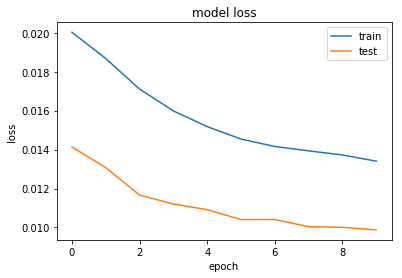

In [125]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


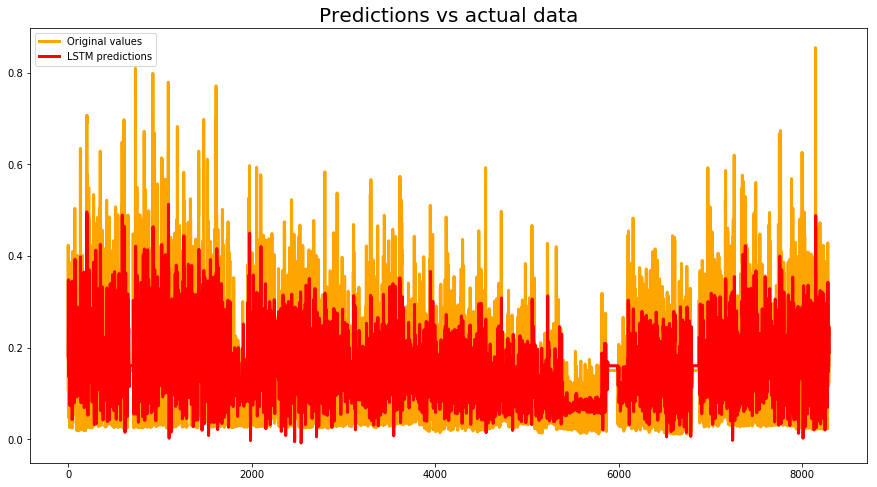

In [148]:
plt.figure(figsize=(15,8))

plt.plot(y_test.reshape(-1, 1), c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()